In [0]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.formula.api as smf
from sklearn import preprocessing
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [0]:
# Load waffle data_labels
df_foxes = pd.read_csv('/home/amit/AmitKushwaha/Courses/Books/StatisticalRethinkingBook/Data/foxes.csv',sep=';')
df_foxes = df_foxes.dropna()

In [0]:
df_foxes.head(20).style.bar(subset=['avgfood'], color='lightgreen').bar(subset=['groupsize'], color='red').bar(subset=['area'], color='yellow').bar(subset='weight', color='blue')

## Model : weight ~ area + groupsize

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bg, ba, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1035.36draws/s]
The acceptance probability does not match the target. It is 0.8864859605780939, but should be close to 0.8. Try to increase the number of tuning steps.


(<Figure size 600x600 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ad0252fd0>],
       dtype=object))

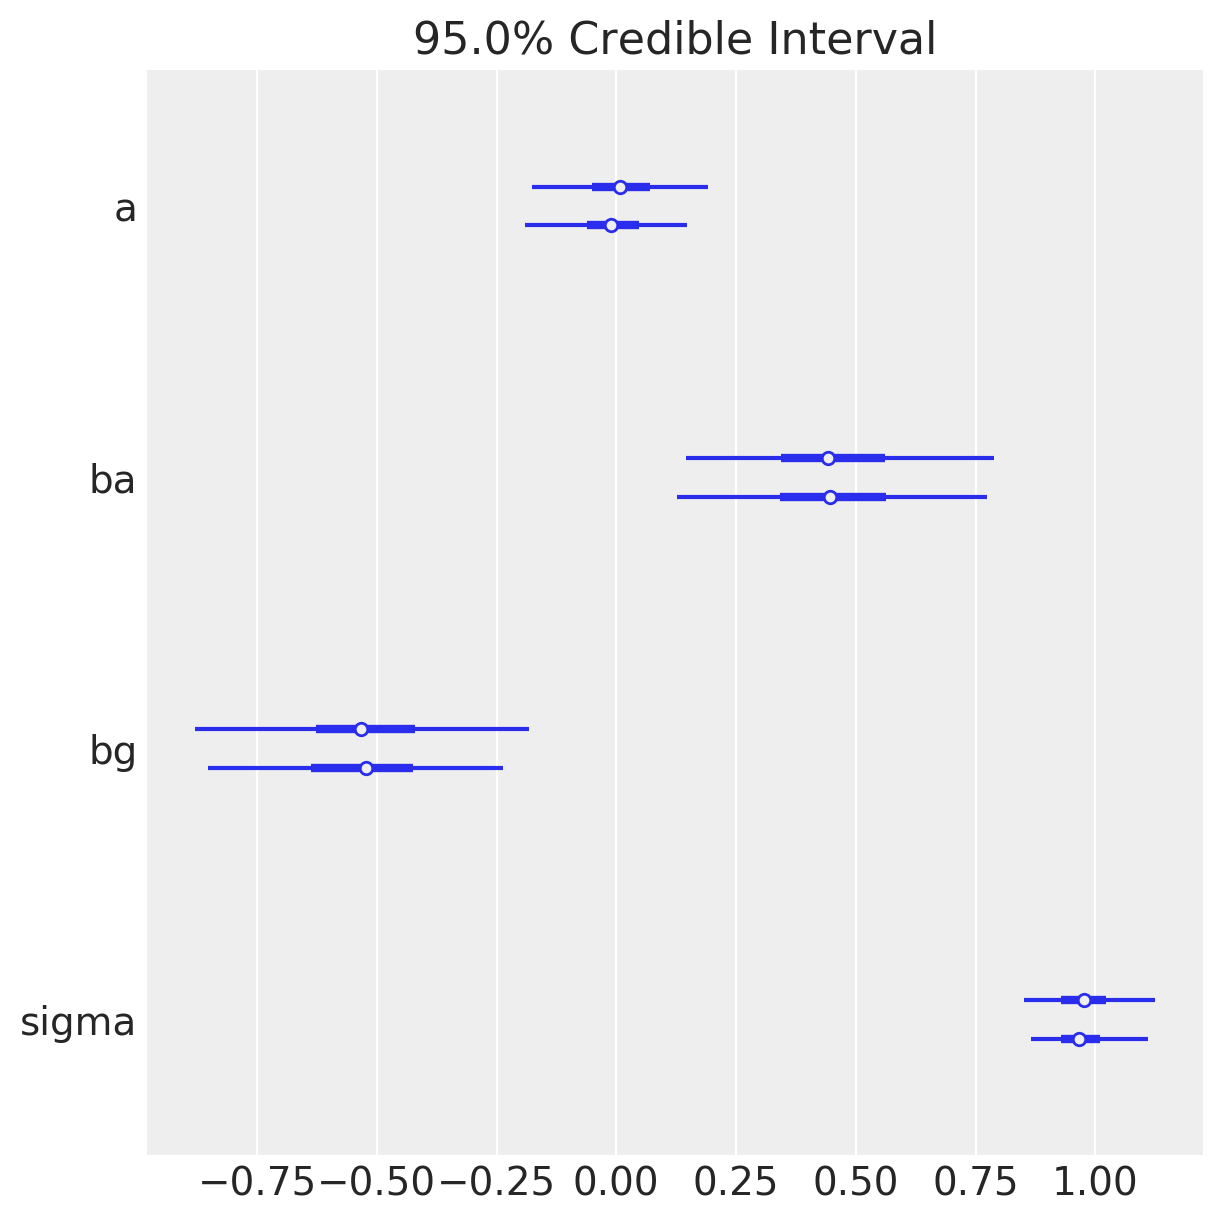

In [11]:
scaler = preprocessing.StandardScaler()
weight = np.squeeze(scaler.fit_transform(df_foxes['weight'].values.reshape(-1,1)))
area = np.squeeze(scaler.fit_transform(df_foxes['area'].values.reshape(-1,1)))
groupsize = np.squeeze(scaler.fit_transform(df_foxes['groupsize'].values.reshape(-1,1)))
    
with pm.Model() as model_1:
    a = pm.Normal('a', mu=10, sigma=10)
    ba = pm.Normal('ba', mu=0, sigma=1)
    bg = pm.Normal('bg', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + ba*area + bg*groupsize)
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=weight)
    trace_1 = pm.sample(cores=2)
    
az.plot_forest(trace_1, var_names=['a','ba','bg','sigma'], figsize=(6,6), credible_interval=.95)

Text(0, 0.5, 'weight')

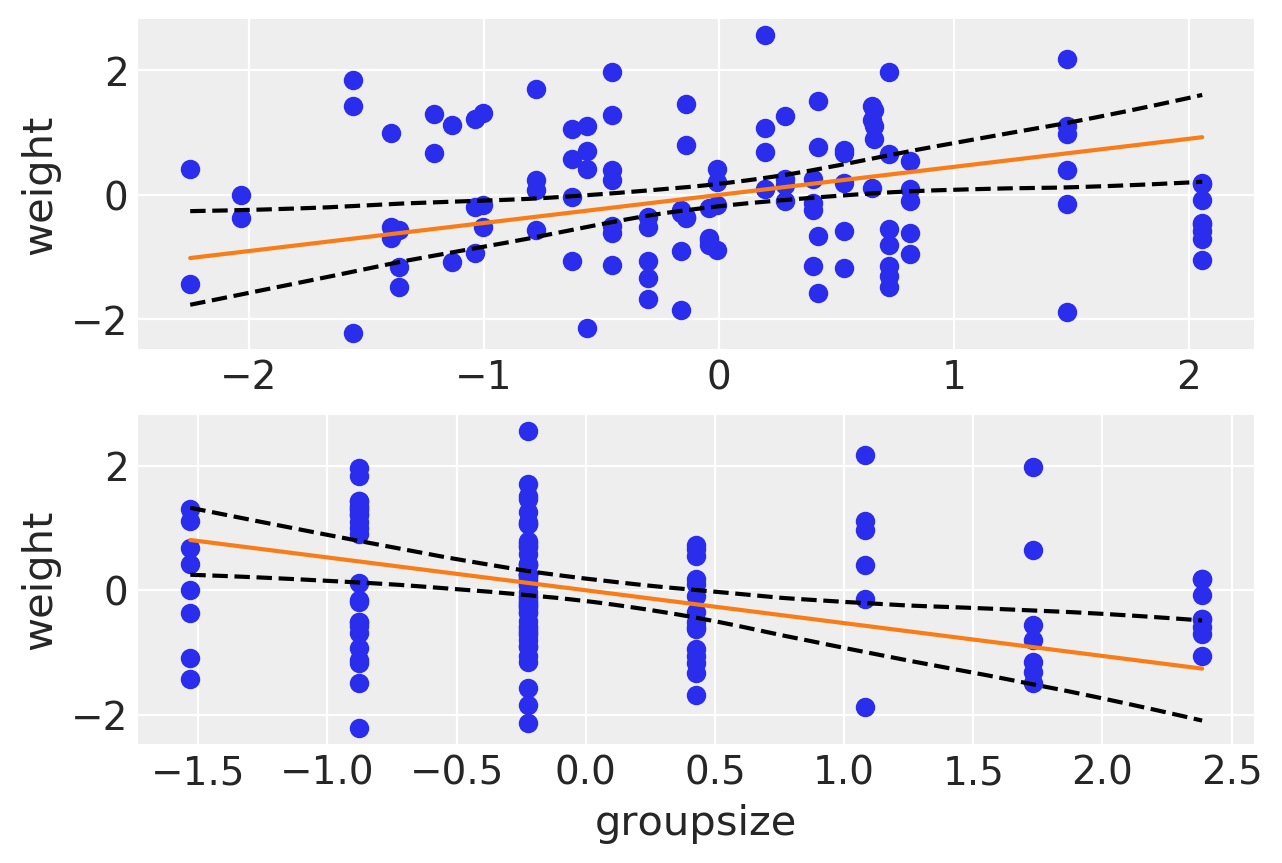

In [25]:
fig, ax = plt.subplots(nrows=2)

area_seq = np.linspace(np.min(area), np.max(area), 50)
mu_mean_area = trace_1['a'] + trace_1['ba']*area_seq[: , None] + trace_1['bg']*np.mean(groupsize)
ax[0].scatter(area, weight)
ax[0].plot(area_seq, mu_mean_area.mean(1), 'C1')
az.plot_hpd(area_seq, mu_mean_area.T, credible_interval=.95,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax[0])
ax[0].set_xlabel('area')
ax[0].set_ylabel('weight')

groupsize_seq = np.linspace(np.min(groupsize), np.max(groupsize), 50)
mu_mean_groupsize = trace_1['a'] + trace_1['ba']*area.mean() + trace_1['bg']*groupsize_seq[:, None]
ax[1].scatter(groupsize, weight)
ax[1].plot(groupsize_seq, mu_mean_groupsize.mean(1), 'C1')
az.plot_hpd(groupsize_seq, mu_mean_groupsize.T, credible_interval=.95,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax[1])
ax[1].set_xlabel('groupsize')
ax[1].set_ylabel('weight')

# Conclusion:
This multiple linear regression model says that both the variables are important. Example of masked relationship. The area and groupsize are positively correlated.

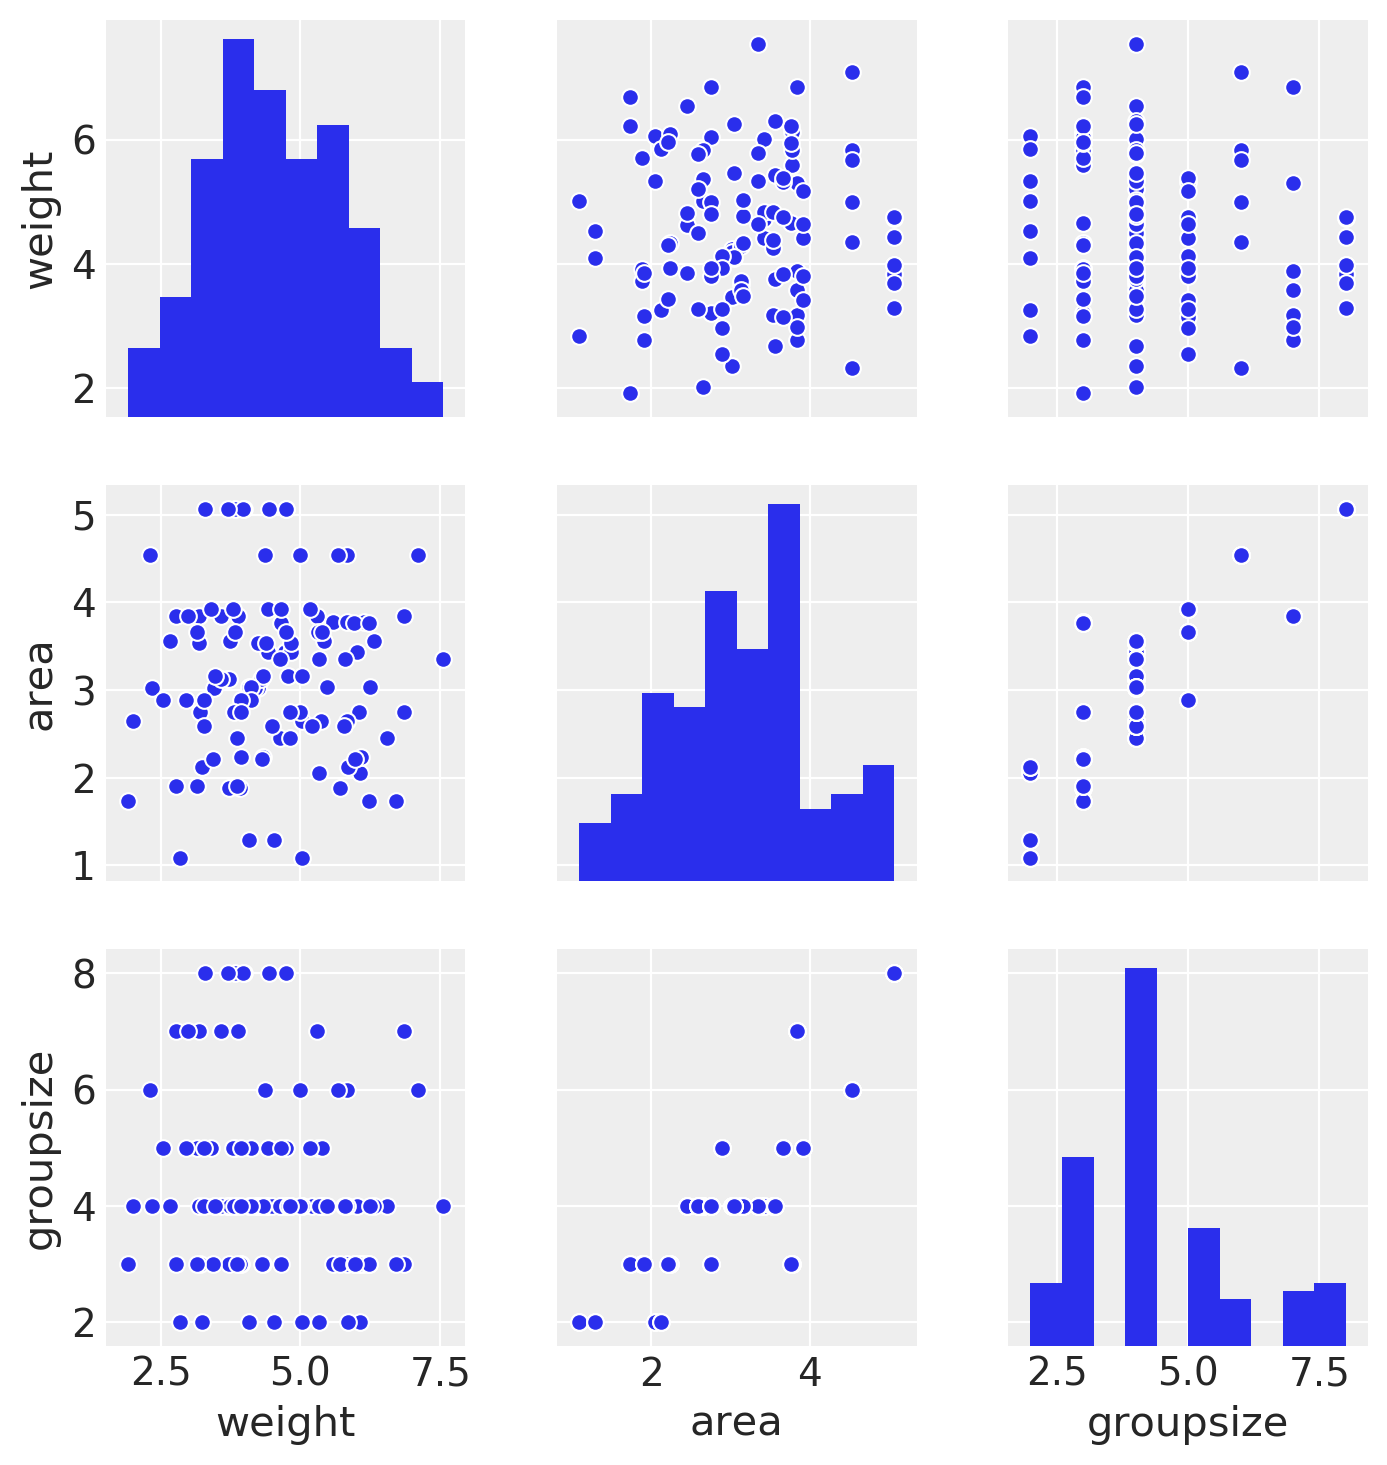

In [27]:
sns.pairplot(df_foxes, vars=['weight', 'area', 'groupsize'])